# Preprocessing and EDA

In [1]:
# Import all packages here
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns 
import random
from datetime import datetime
from tslearn.clustering import TimeSeriesKMeans
from tslearn.clustering import silhouette_score
import time

In [2]:
df_3vac1 = pd.read_csv('../fbc/3VAC1.csv')

In [3]:
df_3vac1['collection_time'] = pd.to_datetime(df_3vac1['collection_time'], format= '%Y-%m-%d %H:%M:%S')

In [4]:
# Amplitude data is stored as string. Changing it to list of integers and storing in original column

def change_to_list(row):
    amplitudes_string = row['amplitudes'][1:-1]
    amplitude_list = amplitudes_string.split(',')

    map_object = map(int, amplitude_list)
    amplitude_list_int = list(map_object)

    return amplitude_list_int

df_3vac1['amplitudes'] = df_3vac1.apply(lambda x: change_to_list(x), axis=1)

In [5]:
# offset, partition, load_dt, site_id are not of use to us, to be dropped
# let us check if oper_status, status_detail, poller_source, span, first, last, bins columns have any unique information for us

cols = ['oper_status', 'status_detail', 'poller_source', 'span', 'first', 'last', 'bins']

for col in cols:
    print("{} -> {}".format(col, df_3vac1[col].nunique()))

oper_status -> 1
status_detail -> 1
poller_source -> 1
span -> 1
first -> 1
last -> 1
bins -> 1


In [6]:
# All of these columns have only 1 unique value, so these columns do not give us any meaningful data
# Dropping...

cols_to_drop = ['offset', 'partition', 'load_dt', 'site_id', 'oper_status', 'status_detail', 'poller_source', 'span', 'first', 'last', 'bins']

df_3vac1.drop(columns=cols_to_drop, axis=1, inplace=True)

In [7]:
# Let us investigate if collection date and times can give us any patterns, else we may drop these columns

def get_hour_min(row):
    time_ = row['collection_time']
    hour_min = "{}:{}".format(time_.time().hour, time_.time().minute)

    return hour_min

df_3vac1['date'] = df_3vac1.apply(lambda x: x['collection_time'].date(), axis=1)
# extracting only hour and minute information
df_3vac1['time'] = df_3vac1.apply(lambda x: get_hour_min(x), axis=1)
df_3vac1.drop(['collection_time'], axis=1, inplace=True)

print(df_3vac1['date'].unique())
# Only 2 unique dates

# Let us retain the date and hour_min information
# This may help give us some insights or visualizations post clustering

[datetime.date(2021, 12, 31) datetime.date(2021, 12, 30)]


In [8]:
df_3vac1
# We will use the amplitude data to get clustering results for similar waveforms from Full Band Capture

,device_id,amplitudes,date,time
0,3c:04:61:fe:1e:81,"[-6262, -6033, -6128, -6434, -6424, -6254, -62...",2021-12-31,14:17
1,58:19:f8:2a:ce:a7,"[-6612, -6627, -6640, -6914, -7127, -6670, -64...",2021-12-31,3:37
2,a8:97:cd:41:0e:f1,"[-4500, -4510, -4660, -4710, -4710, -4870, -48...",2021-12-31,22:12
3,b0:da:f9:3e:5d:c6,"[-4570, -4590, -4670, -4690, -4690, -4660, -46...",2021-12-31,2:25
4,d4:04:cd:d6:f3:5d,"[-6678, -6531, -6430, -6245, -6531, -6476, -66...",2021-12-31,8:23
...,...,...,...,...
1041,98:52:4a:07:80:ff,"[-1262, -1436, -1118, -1104, -1057, -1363, -11...",2021-12-31,15:59
1042,98:f7:d7:b8:e6:f9,"[-5411, -5340, -5381, -5258, -5445, -5364, -52...",2021-12-31,16:6
1043,08:a7:c0:a3:f0:ba,"[-1711, -1483, -1383, -1197, -985, -1064, -101...",2021-12-31,13:47
1044,a8:97:cd:40:37:a5,"[-4720, -4740, -4880, -4920, -4920, -5030, -50...",2021-12-31,11:30


In [9]:
# Let us check the number of captures of unique devices
devices = df_3vac1['device_id'].unique()

# Have to populate this list. First index indicates 1 capture, 2nd indicates 2 captures, 3rd indicates 3 captures, and  4th indicates 3+ captures
num_captures = [0, 0, 0, 0]
for device in devices:
    df_temp = df_3vac1[df_3vac1['device_id'] == device]
    length = df_temp.shape[0]
    if (length == 1):
        num_captures[0] += 1
    elif (length == 2):
        num_captures[1] += 1
    elif (length == 3):
        num_captures[2] += 1
    else:
        num_captures[3] += 1

print(num_captures)

# Most devices have 3 captures, few have 1,2, or 3+ captures

[2, 4, 340, 4]


In [10]:
# Let us now check the length of the amplitude lists

df_3vac1['amp_len'] = df_3vac1.apply(lambda x:len(x['amplitudes']), axis=1)
print(df_3vac1['amp_len'].nunique())

# All amplitude lists have length of 8704, which means no sensors have missing data points in the Full Band Capture
df_3vac1.drop(['amp_len'], axis=1, inplace=True)

1


In [11]:
# Explode list of integer array into dataframe form
amps = pd.DataFrame(df_3vac1['amplitudes'].to_list())

# Modeling

In [12]:
# Although this is a frequency domain waveform, we can adapt time series algorithms for our use, because 
# in the end both are just waveforms - arrays of numbers!

# TimeSeriesKMeans takes a lot of time to compute for high number of waveforms when the metric is dtw
# We will speed up the process by considering only 2000 data points which have highest variation 
# (i.e. highest range/std dev - can be set as a parameter) instead of all 8704 array elements

###########################
### SET ALL PARAMS HERE ###
###########################

# DISTANCE_METRIC = euclidean/dtw
# NUM_CLUSTERS is set automatically based on best silhouette score
# VARIATION_PARAM = range/stddev

MAX_ITER = 10
DISTANCE_METRIC = 'euclidean'
VARIATION_PARAM = 'stddev'

In [13]:
# We select best K through best Silhouette score after clustering with different values of K (2 <= K <= 10) 

silhouette_score_list = []
dtw_kmeans_final_model = TimeSeriesKMeans()
max_silhouette_score = 0
y_pred_final = []

amps_final = amps.copy()

for k in np.arange(2,11,1):    
    dtw_kmeans_model_temp = TimeSeriesKMeans(n_clusters=k, metric=DISTANCE_METRIC, 
                                             max_iter=MAX_ITER, random_state = 101)
    
    # Special Handling for dtw
    if (DISTANCE_METRIC == 'dtw'):
        amps_new = amps.copy()
        variation_list = []

        length = int(amps_new.shape[1])
        for i in np.arange(0, length, 1):
            df_temp = amps_new.iloc[: , i:i+1]
            value_list = df_temp.values.tolist()
            if (VARIATION_PARAM == 'range'):
                variation_ = max(value_list)[0] - min(value_list)[0]
            elif (VARIATION_PARAM == 'stddev'):
                variation_ = np.std(value_list)
            variation_list.append(variation_)

        amps_final_new = amps_new.copy().T
        amps_final_new['range'] = range_list
        amps_final_new = amps_final_new.sort_values(by=['range'], ascending=False).drop(['range'],axis=1).reset_index(drop=True).T
        amps_final = amps_final_new.iloc[: , :2000]
    
    amps_temp = amps_final.copy()
    y_pred_temp = dtw_kmeans_model_temp.fit_predict(amps_temp)
    amps_temp['combined'] = amps_temp.values.tolist()
    amps_temp['y_pred'] = y_pred_temp
    score_temp = silhouette_score(X = amps_temp.iloc[: , :8704], labels = y_pred_temp, metric = DISTANCE_METRIC)
    silhouette_score_list.append(score_temp)
    max_silhouette_score = max(silhouette_score_list)
    if (max_silhouette_score == score_temp):
        dtw_kmeans_final_model = dtw_kmeans_model_temp
        y_pred_final = y_pred_temp
    
NUM_CLUSTERS = silhouette_score_list.index(max_silhouette_score)+2

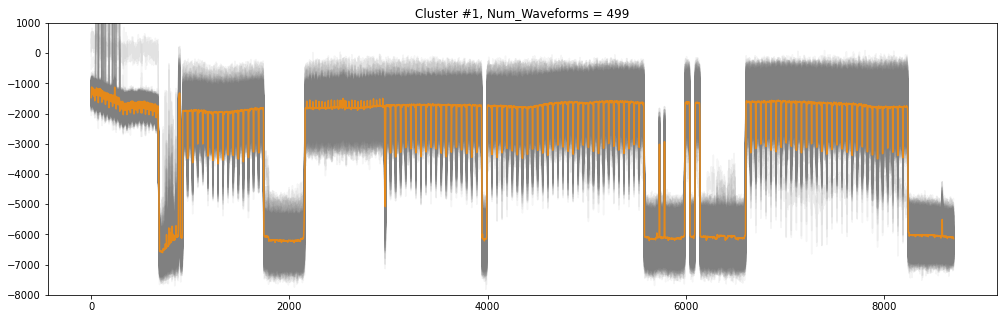

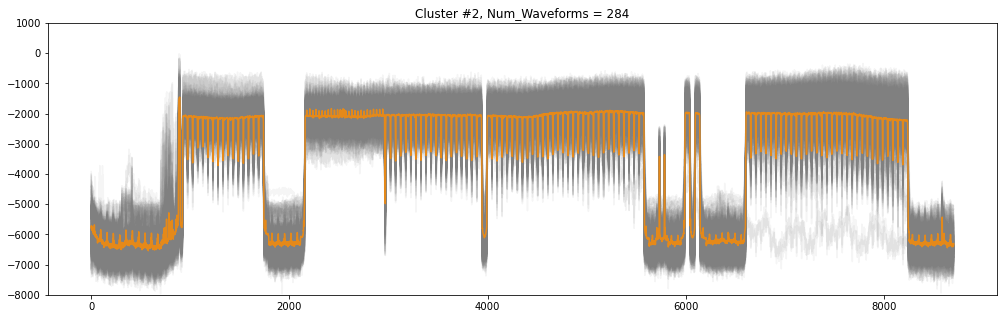

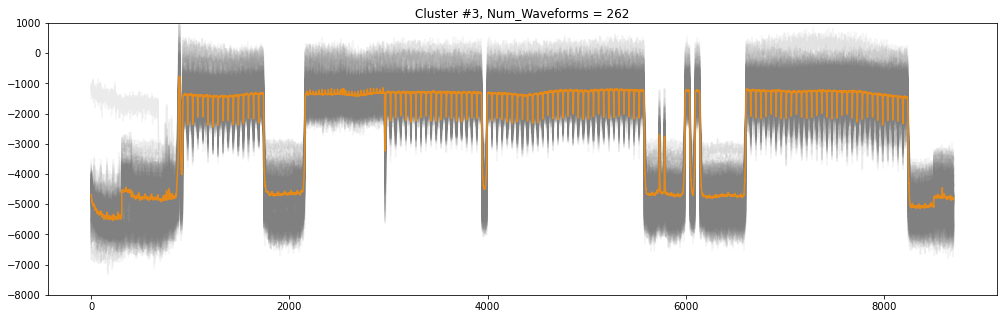

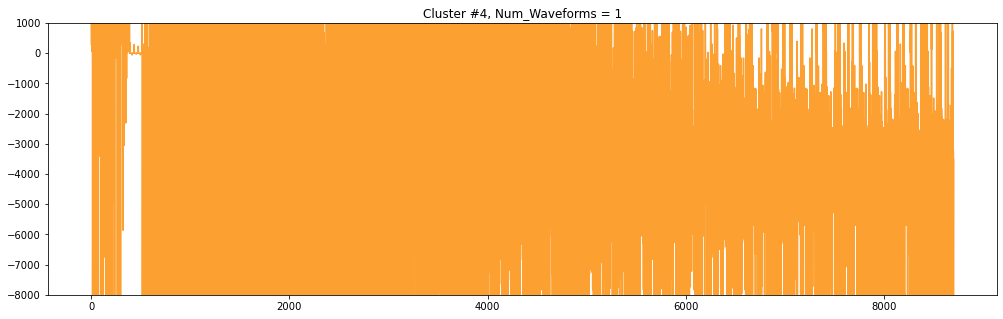

In [16]:
amps_clusters = []

for i in np.arange(0, NUM_CLUSTERS, 1):
    amps_clusters.append(amps_final[amps_final['y_pred'] == i]['combined'].reset_index(drop=True))
    
for i in np.arange(0, NUM_CLUSTERS, 1):
    plt.figure(figsize=(17,5))
    for j in np.arange(0, len(amps_clusters[i]), 1):
        plt.plot(amps_clusters[i][j], color='grey', alpha=0.08)
    plt.plot(dtw_kmeans_final_model.cluster_centers_[i], color='darkorange', alpha=0.8)
    num_waveforms_in_cluster = len(amps_clusters[i])
    plt.title('Cluster #{}, Num_Waveforms = {}'.format(i+1, num_waveforms_in_cluster))
    plt.ylim(-8000,1000)
    plt.show()

In [17]:
# Show Final Silhouette Score after clustering

print("The silhouette_score after final clustering is\033[1m {}".format(max_silhouette_score))

The silhouette_score after final clustering is 0.44850648448156727


# The Fourier Approach

In [18]:
# As this is a full band frequency capture, we can try transforming it into time domain waveform 
# by using Inverse Fourier Transform, and check if this improves our clustering results in any way

In [19]:
from scipy.fft import irfft

In [20]:
wave_df = pd.DataFrame(df_3vac1['amplitudes'])
wave_df['time_wave'] = wave_df['amplitudes'].apply(lambda x: irfft(x))
wave_df.drop(['amplitudes'], axis=1, inplace=True)

In [21]:
ts = pd.DataFrame(wave_df['time_wave'].to_list())

In [22]:
ts_final = ts.iloc[: , :17406].copy()

In [23]:
silhouette_score_list_ts = []

for k in np.arange(2,11,1):  
    ts_temp = ts_final.copy()
    dtw_kmeans_model_temp = TimeSeriesKMeans(n_clusters=k, metric=DISTANCE_METRIC, 
                                             max_iter=MAX_ITER, random_state = 101)
    y_pred_temp = dtw_kmeans_model_temp.fit_predict(ts_temp)
    ts_temp['combined'] = ts_temp.values.tolist()
    ts_temp['y_pred'] = y_pred_temp
    score = silhouette_score(X = ts_temp.iloc[: , :17406], labels = y_pred_temp, metric = DISTANCE_METRIC)
    silhouette_score_list_ts.append(score)

In [24]:
silhouette_score_list

[0.4467485724313497,
 0.443260156870188,
 0.44850648448156727,
 0.39187864602234446,
 0.3726877311660598,
 0.3436932175038725,
 0.334620641304548,
 0.3421759541631126,
 0.3195340329507307]

In [25]:
silhouette_score_list_ts

[0.44666686993678506,
 0.4432057698816877,
 0.44845318662834577,
 0.39186693202907386,
 0.372677654095038,
 0.34369911806865433,
 0.33461775547464107,
 0.34217926580170677,
 0.3195413786660721]

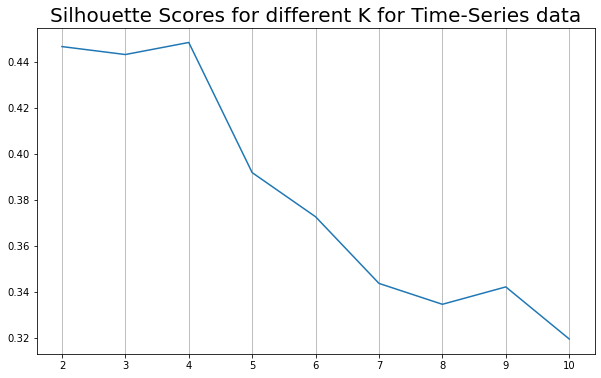

In [26]:
Y = silhouette_score_list_ts
X = np.arange(2,11,1)

plt.figure(figsize=(10,6))
plt.title('Silhouette Scores for different K for Time-Series data', fontdict = {'fontsize' : 20})
plt.plot(X,Y)
plt.grid(axis = 'x')
plt.show()

In [27]:
# Although the silhouette scores are very slightly different for clusters formed from frequency capture and
# transformed time-domain data, the difference is very minor and not impactful at all. Thus we will only use 
# frequency amplitudes for clustering

# Investigate Clusters

In [28]:
# We should investigate clusters to see if devices with unique device_id belong to the same clusters or not

In [35]:
df_clusters = pd.DataFrame(df_3vac1['device_id'])
df_clusters['cluster'] = y_pred_final

In [37]:
unique_devices = df_clusters['device_id'].unique().tolist()

In [45]:
for device in unique_devices:
    df_subset = df_clusters[df_clusters['device_id'] == device]
    temp_cluster_list = df_subset['cluster'].tolist()
    flag = 'yes'
    if (len(set(temp_cluster_list)) != 1):
        flag = 'no'
        
if (flag == 'no'):
    print('Not all devices with unique device_ids belong to same cluster')
else:
    print('All OK')

All OK


In [46]:
# It seems that all devices with unique device_ids have been clustered into the same cluster
# This also asligns with logical expectation

# Check Waveforms

In [9]:
df_3vac1

,device_id,amplitudes,date,time
0,3c:04:61:fe:1e:81,"[-6262, -6033, -6128, -6434, -6424, -6254, -62...",2021-12-31,14:17
1,58:19:f8:2a:ce:a7,"[-6612, -6627, -6640, -6914, -7127, -6670, -64...",2021-12-31,3:37
2,a8:97:cd:41:0e:f1,"[-4500, -4510, -4660, -4710, -4710, -4870, -48...",2021-12-31,22:12
3,b0:da:f9:3e:5d:c6,"[-4570, -4590, -4670, -4690, -4690, -4660, -46...",2021-12-31,2:25
4,d4:04:cd:d6:f3:5d,"[-6678, -6531, -6430, -6245, -6531, -6476, -66...",2021-12-31,8:23
...,...,...,...,...
1041,98:52:4a:07:80:ff,"[-1262, -1436, -1118, -1104, -1057, -1363, -11...",2021-12-31,15:59
1042,98:f7:d7:b8:e6:f9,"[-5411, -5340, -5381, -5258, -5445, -5364, -52...",2021-12-31,16:6
1043,08:a7:c0:a3:f0:ba,"[-1711, -1483, -1383, -1197, -985, -1064, -101...",2021-12-31,13:47
1044,a8:97:cd:40:37:a5,"[-4720, -4740, -4880, -4920, -4920, -5030, -50...",2021-12-31,11:30


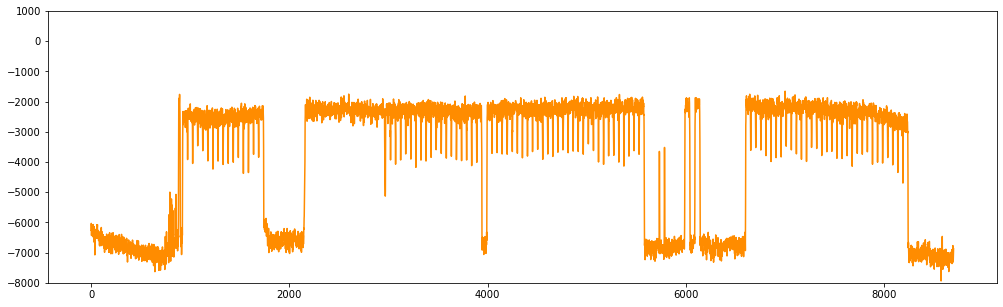

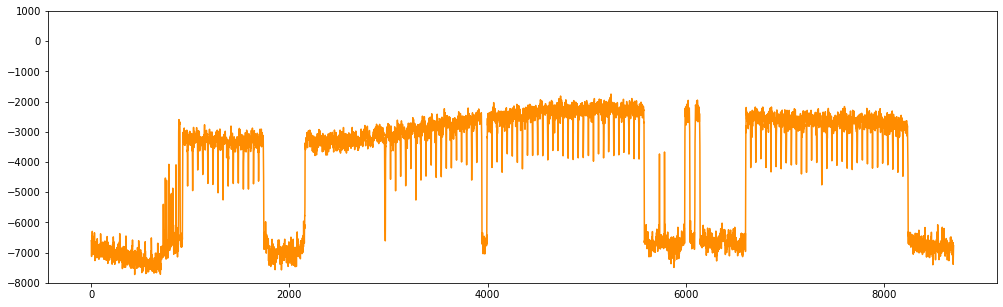

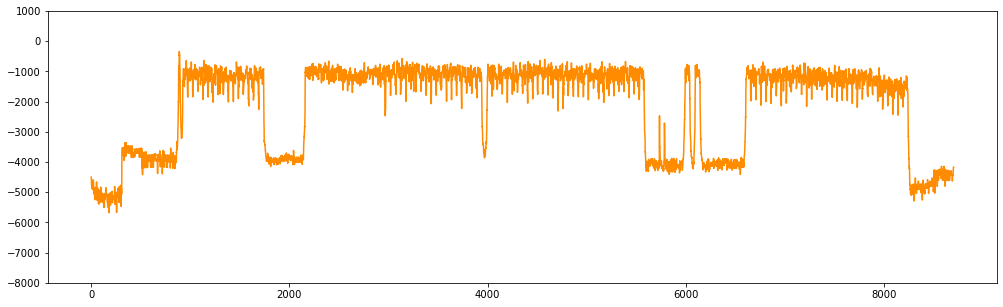

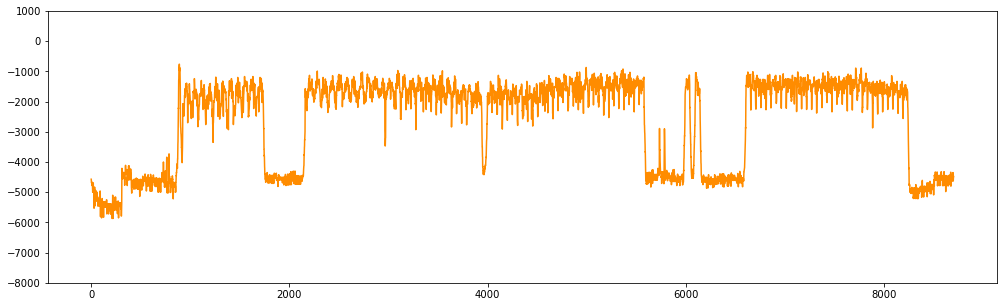

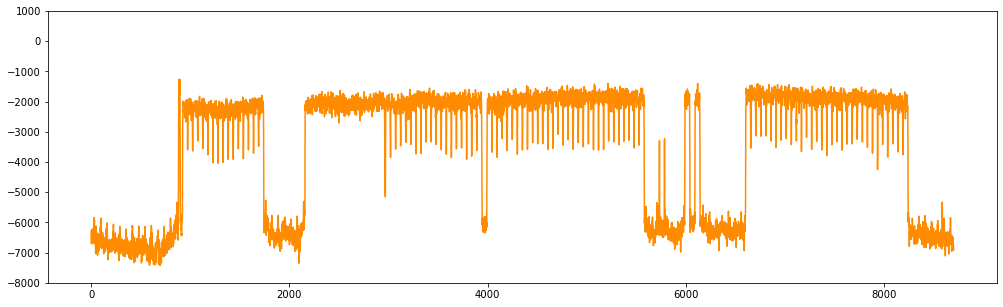

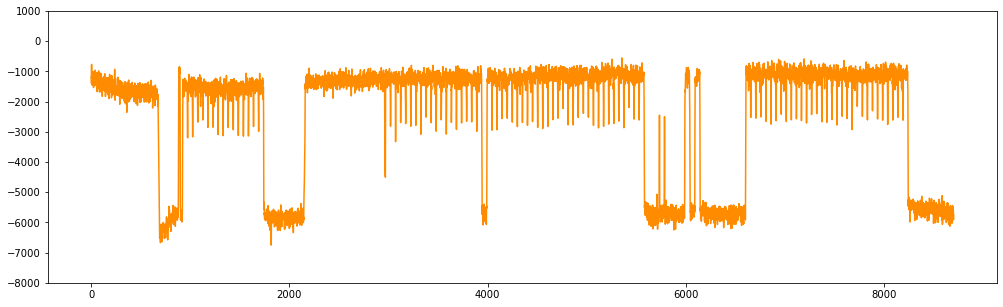

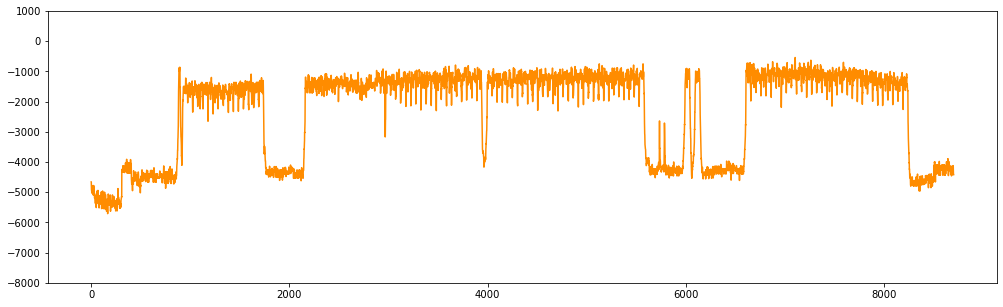

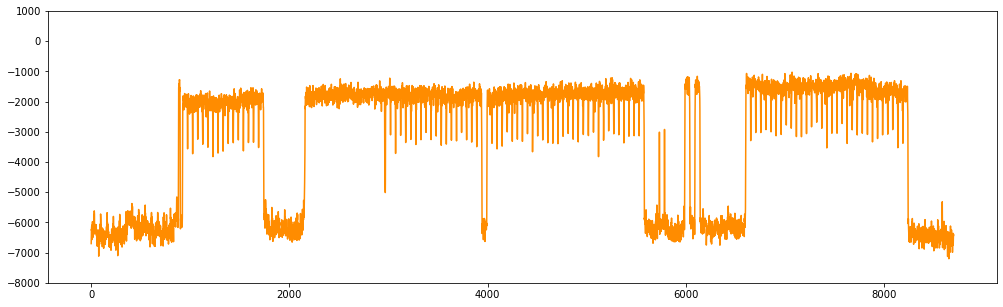

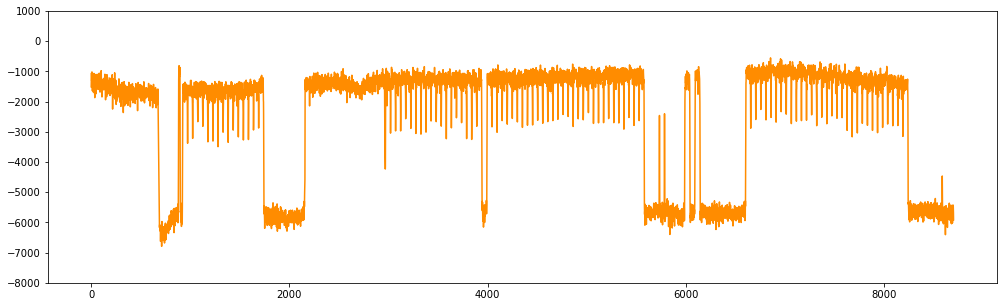

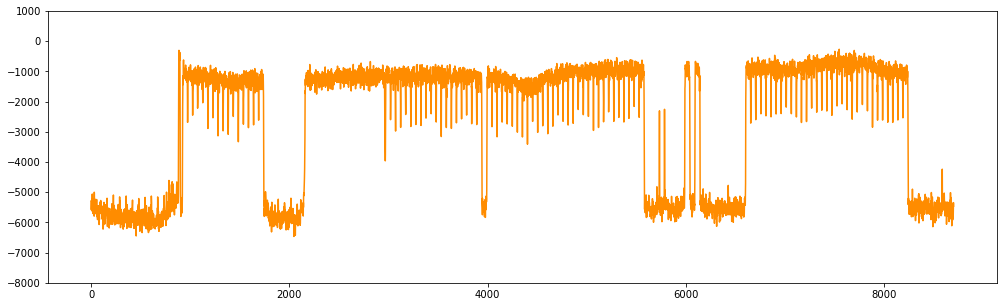

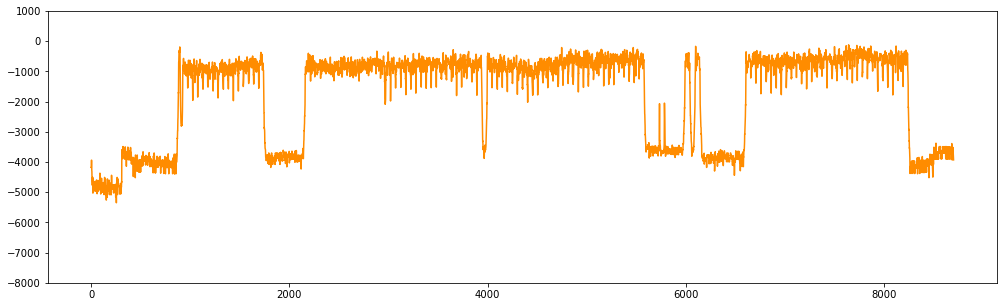

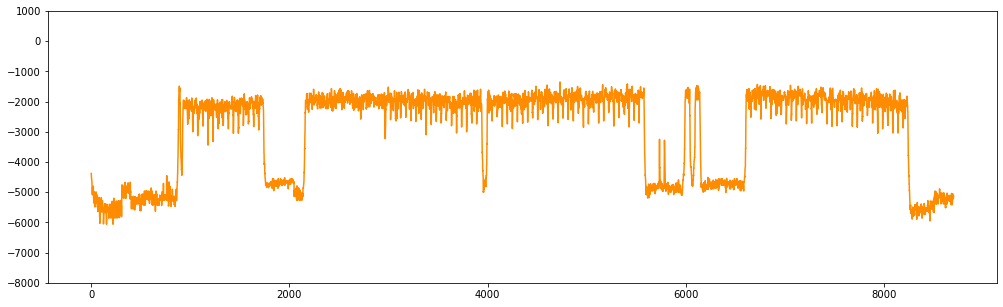

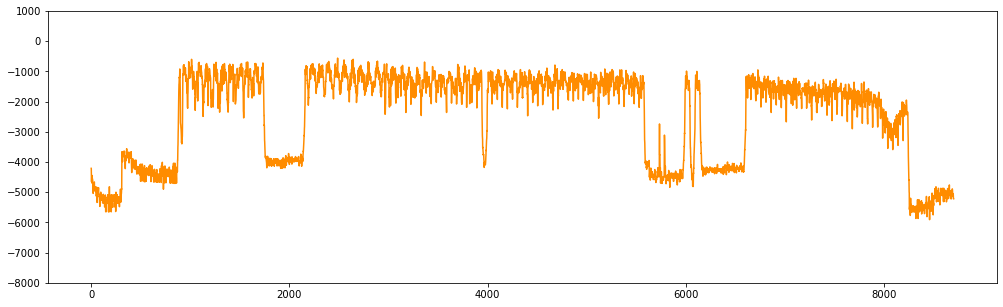

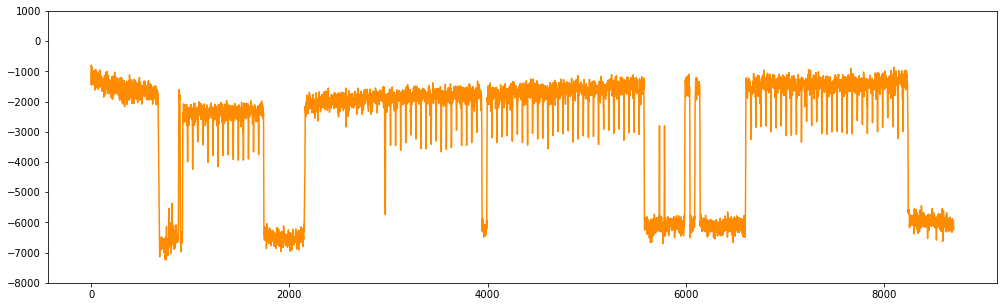

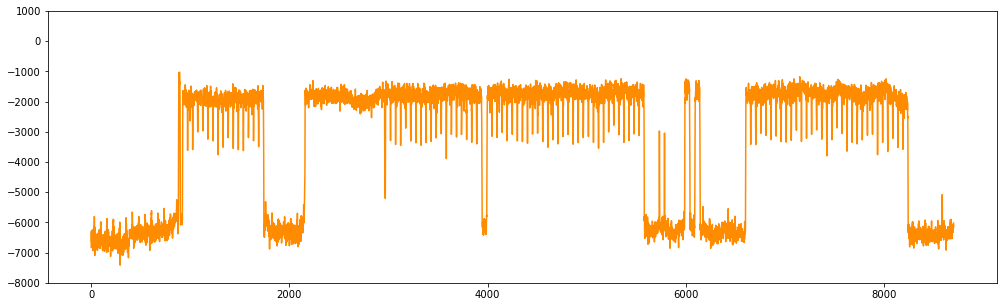

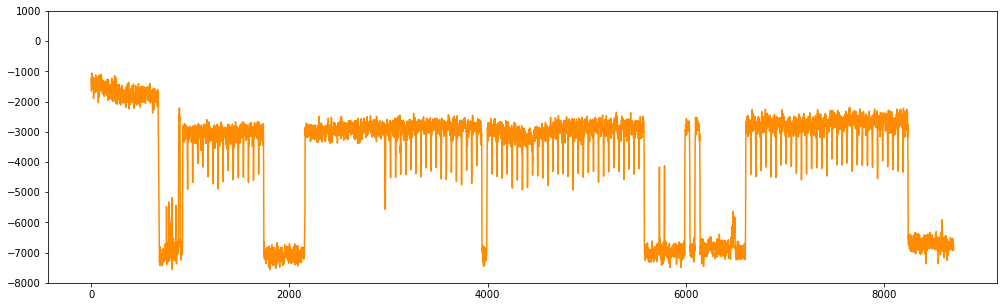

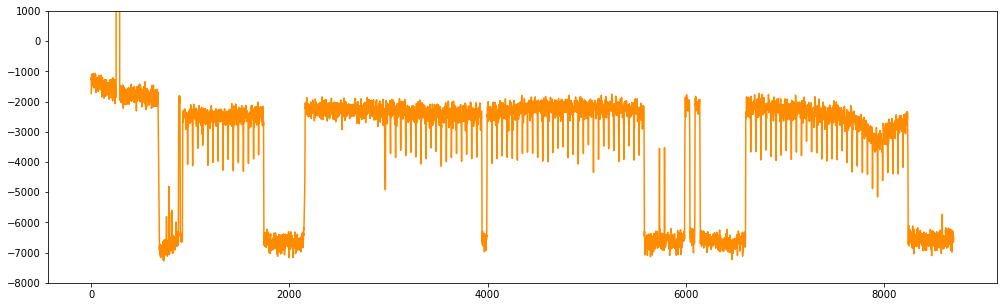

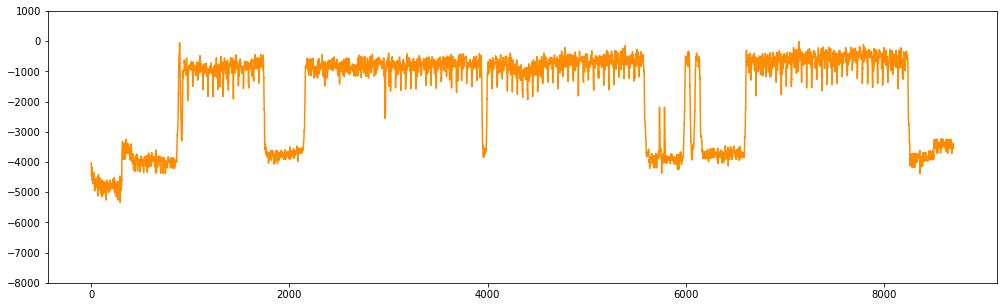

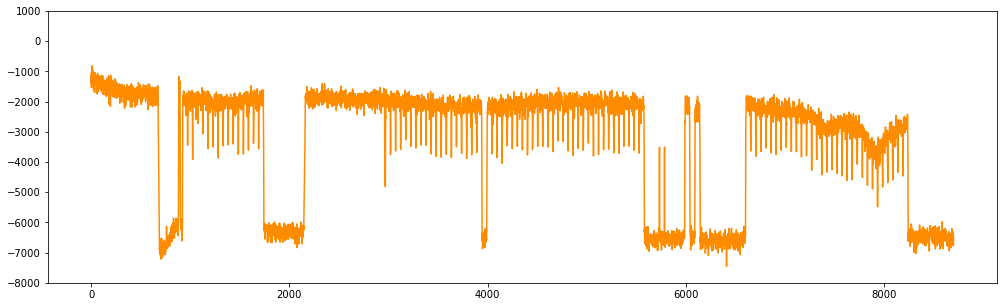

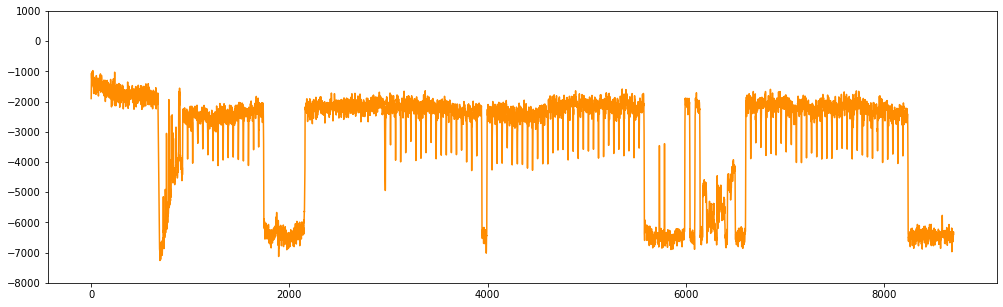

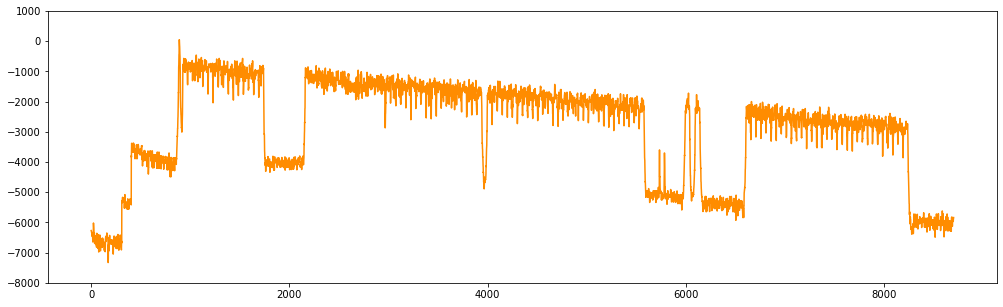

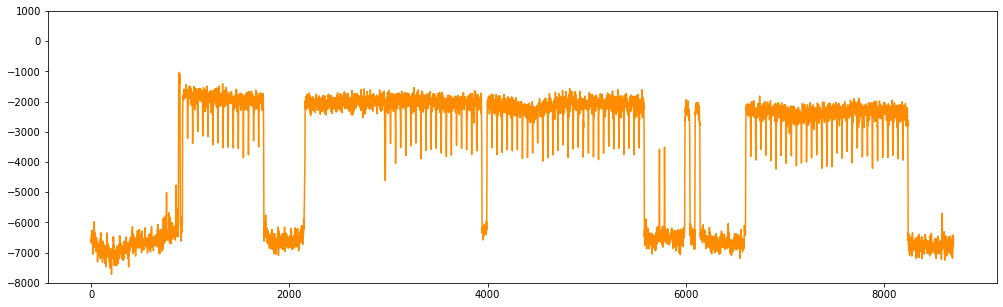

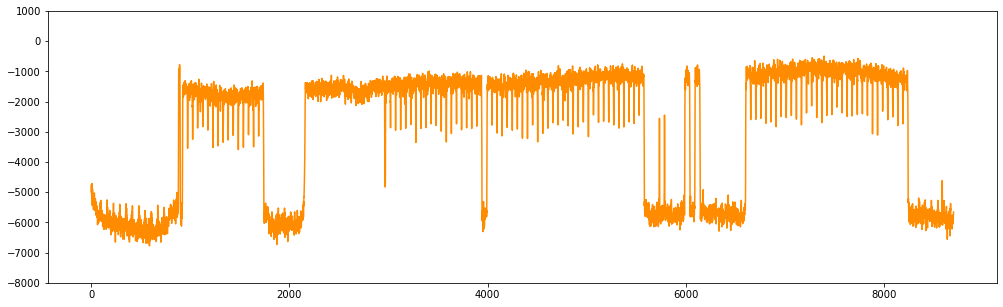

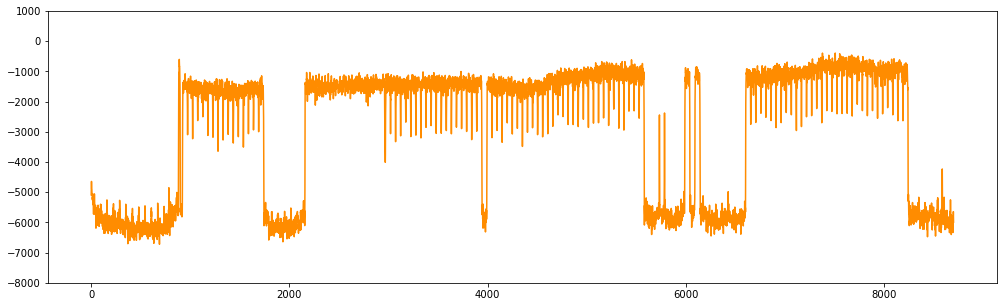

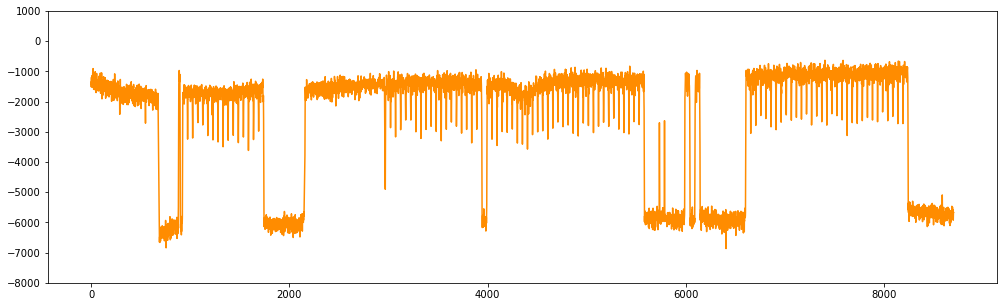

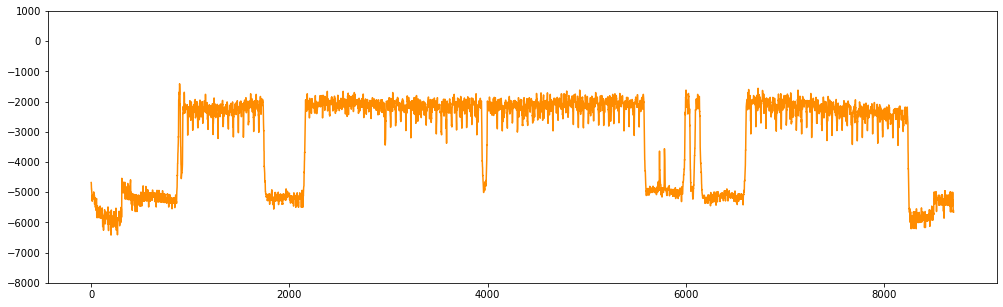

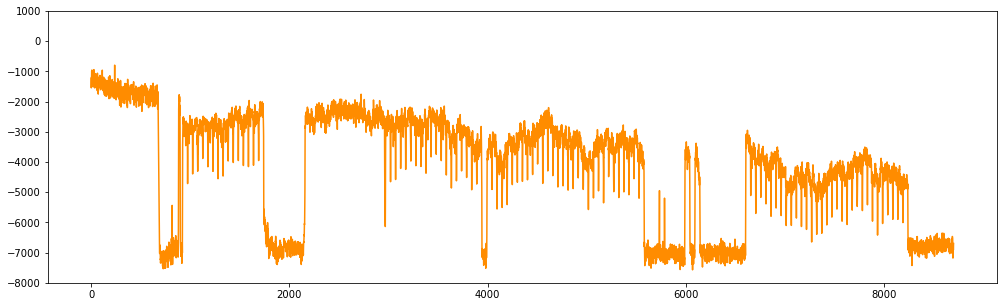

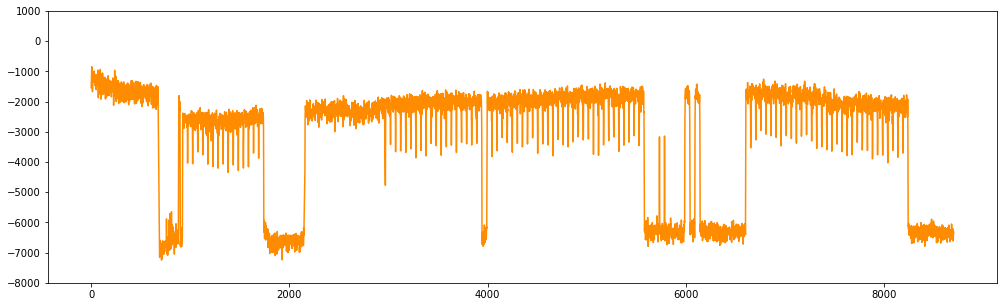

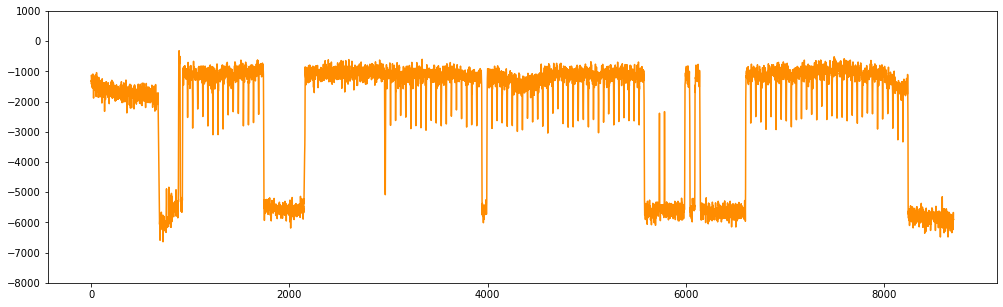

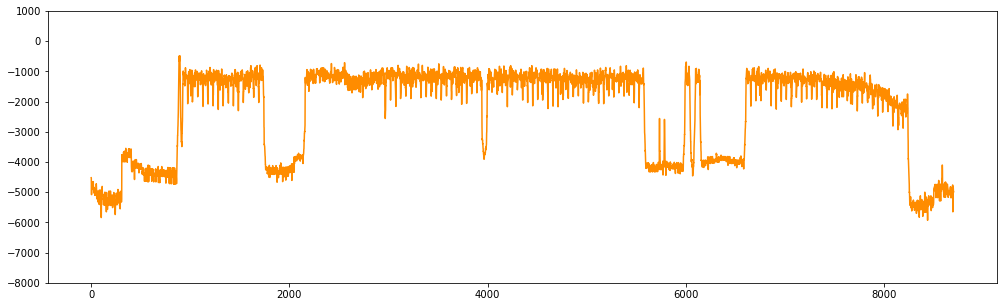

In [14]:
def plot_amps(amps):
    plt.figure(figsize=(17,5))
    plt.plot(amps, color='darkorange')
    plt.ylim(-8000,1000)
    plt.show()

temp = df_3vac1['amplitudes'][0:30].apply(lambda x:plot_amps(x))